# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [41]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [42]:
# Examine the data: check number of rows and number of columns
churn.shape

(46206, 21)

**DATA CLEANING**

This section will check for missing values in churn. I will eliminate these missing values if I feel they will influence the overall conclusion of the data.

In [43]:
# Print full summary
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46130 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

In [44]:
# Return the number of missing values in the data set
churn.isnull().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

AGE, COUNTRY_METRO_REGION, STATE, RECON_SMS_NEXT_MTH, RECON_TELE_NEXT_MTH and RECON_EMAIL_NEXT_MTH are the only columns with missing values. With just one null value, COUNTRY_METRO_REGION and STATE will have little influence on the data; however, AGE has 76 missing values and RECON_SMS_NEXT_MTH, RECON_TELE_NEXT_MTH, and RECON_EMAIL_NEXT MTH all have 17790 missing values. To avoid errors due to missing values, I will use fillna() to backward fill the NaN values that are present in the data frame.

In [47]:
# Backward fill the missing values in the dataset 
churn.fillna(method="bfill", inplace=True)

Checking to see whether the columns satisfy expectations.

In [48]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46206 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

Displaying cleaned data

In [49]:
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,0.0,0.0,0.0
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,0.0,0.0,0.0
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,0.0,0.0,0.0
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,0.0,0.0,0.0
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,0.0,0.0,0.0


**EXPLORATORY DATA ANALYSIS**

Now that the two datasets has been cleaned, we can now build and evaluate a predictive model for churn

> NUMBER OF CHURN

In [55]:
print("Number Churning:", churn.CHURN_IND.sum())
print("Number Not Churning:", churn.CHURN_IND.size - churn.CHURN_IND.sum())

Number Churning: 17790
Number Not Churning: 28416


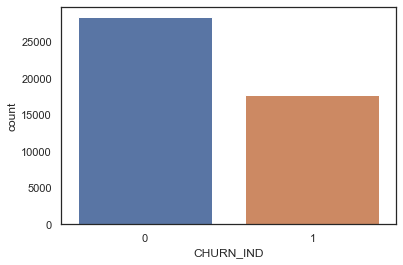

In [71]:
sns.set(style="white", palette="deep", color_codes=True)
sns.despine(left=True)
sns.countplot(churn["CHURN_IND"]);

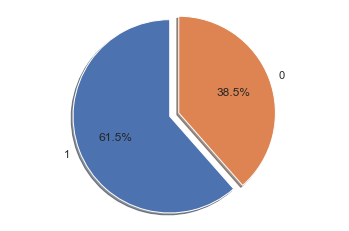

In [65]:
plt.pie(churn["CHURN_IND"].value_counts(),explode=(0,0.1), autopct='%1.1f%%',
        shadow=True, startangle=90,labels=churn["CHURN_IND"].unique())
plt.axis('equal') ;

As we can see, the number of people who are not churning is more than double the number of people who are churning. As a result, the dataset is unbalanced.

> VISUALISATION

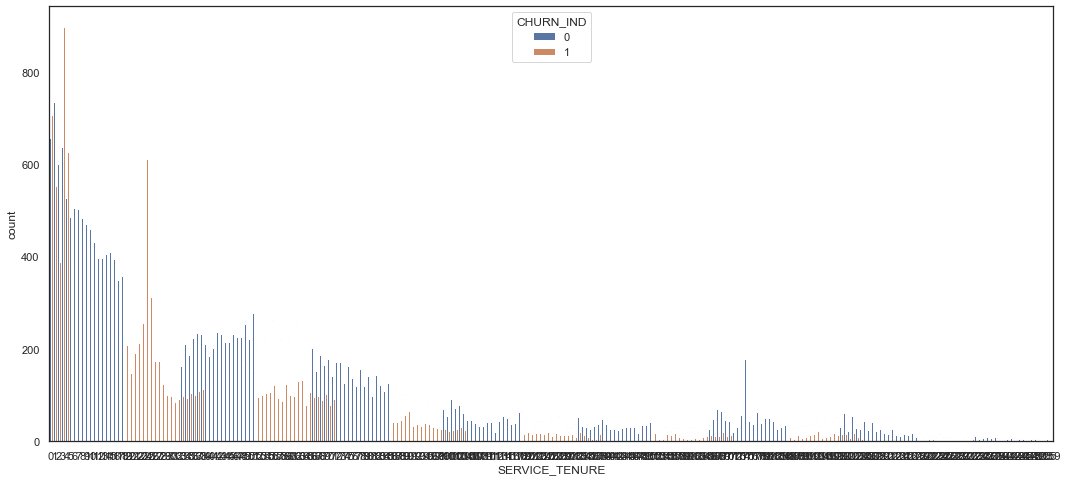

In [90]:
plt.subplots(figsize=(18, 8))
sns.countplot(churn["SERVICE_TENURE"],hue = churn["CHURN_IND"]);

In [73]:
# Calculating statistical data
churn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CUST_ID,46206.0,42335.196879,22100.432751,1.00,24951.75,43261.00,61132.75,79500.00
ACCOUNT_TENURE,46206.0,45.874627,33.077927,0.00,14.00,44.00,77.00,120.00
ACCT_CNT_SERVICES,46206.0,1.555707,0.835529,1.00,1.00,1.00,2.00,4.00
AGE,46206.0,41.412046,15.266354,-4.00,28.00,40.00,52.00,116.00
SERVICE_TENURE,46206.0,50.318617,51.925537,0.00,11.00,35.00,69.00,259.00
PLAN_ACCESS_FEE,46206.0,51.364858,20.855419,8.18,36.36,54.54,72.72,234.54
PLAN_TENURE,46206.0,10.846708,9.769887,0.00,3.00,8.00,16.00,147.00
MONTHS_OF_CONTRACT_REMAINING,46206.0,8.237112,8.341476,0.00,0.00,7.00,16.00,24.00
LAST_FX_CONTRACT_DURATION,46206.0,20.349825,8.034631,0.00,24.00,24.00,24.00,36.00
PREV_CONTRACT_DURATION,46206.0,15.249968,10.982958,0.00,0.00,24.00,24.00,36.00


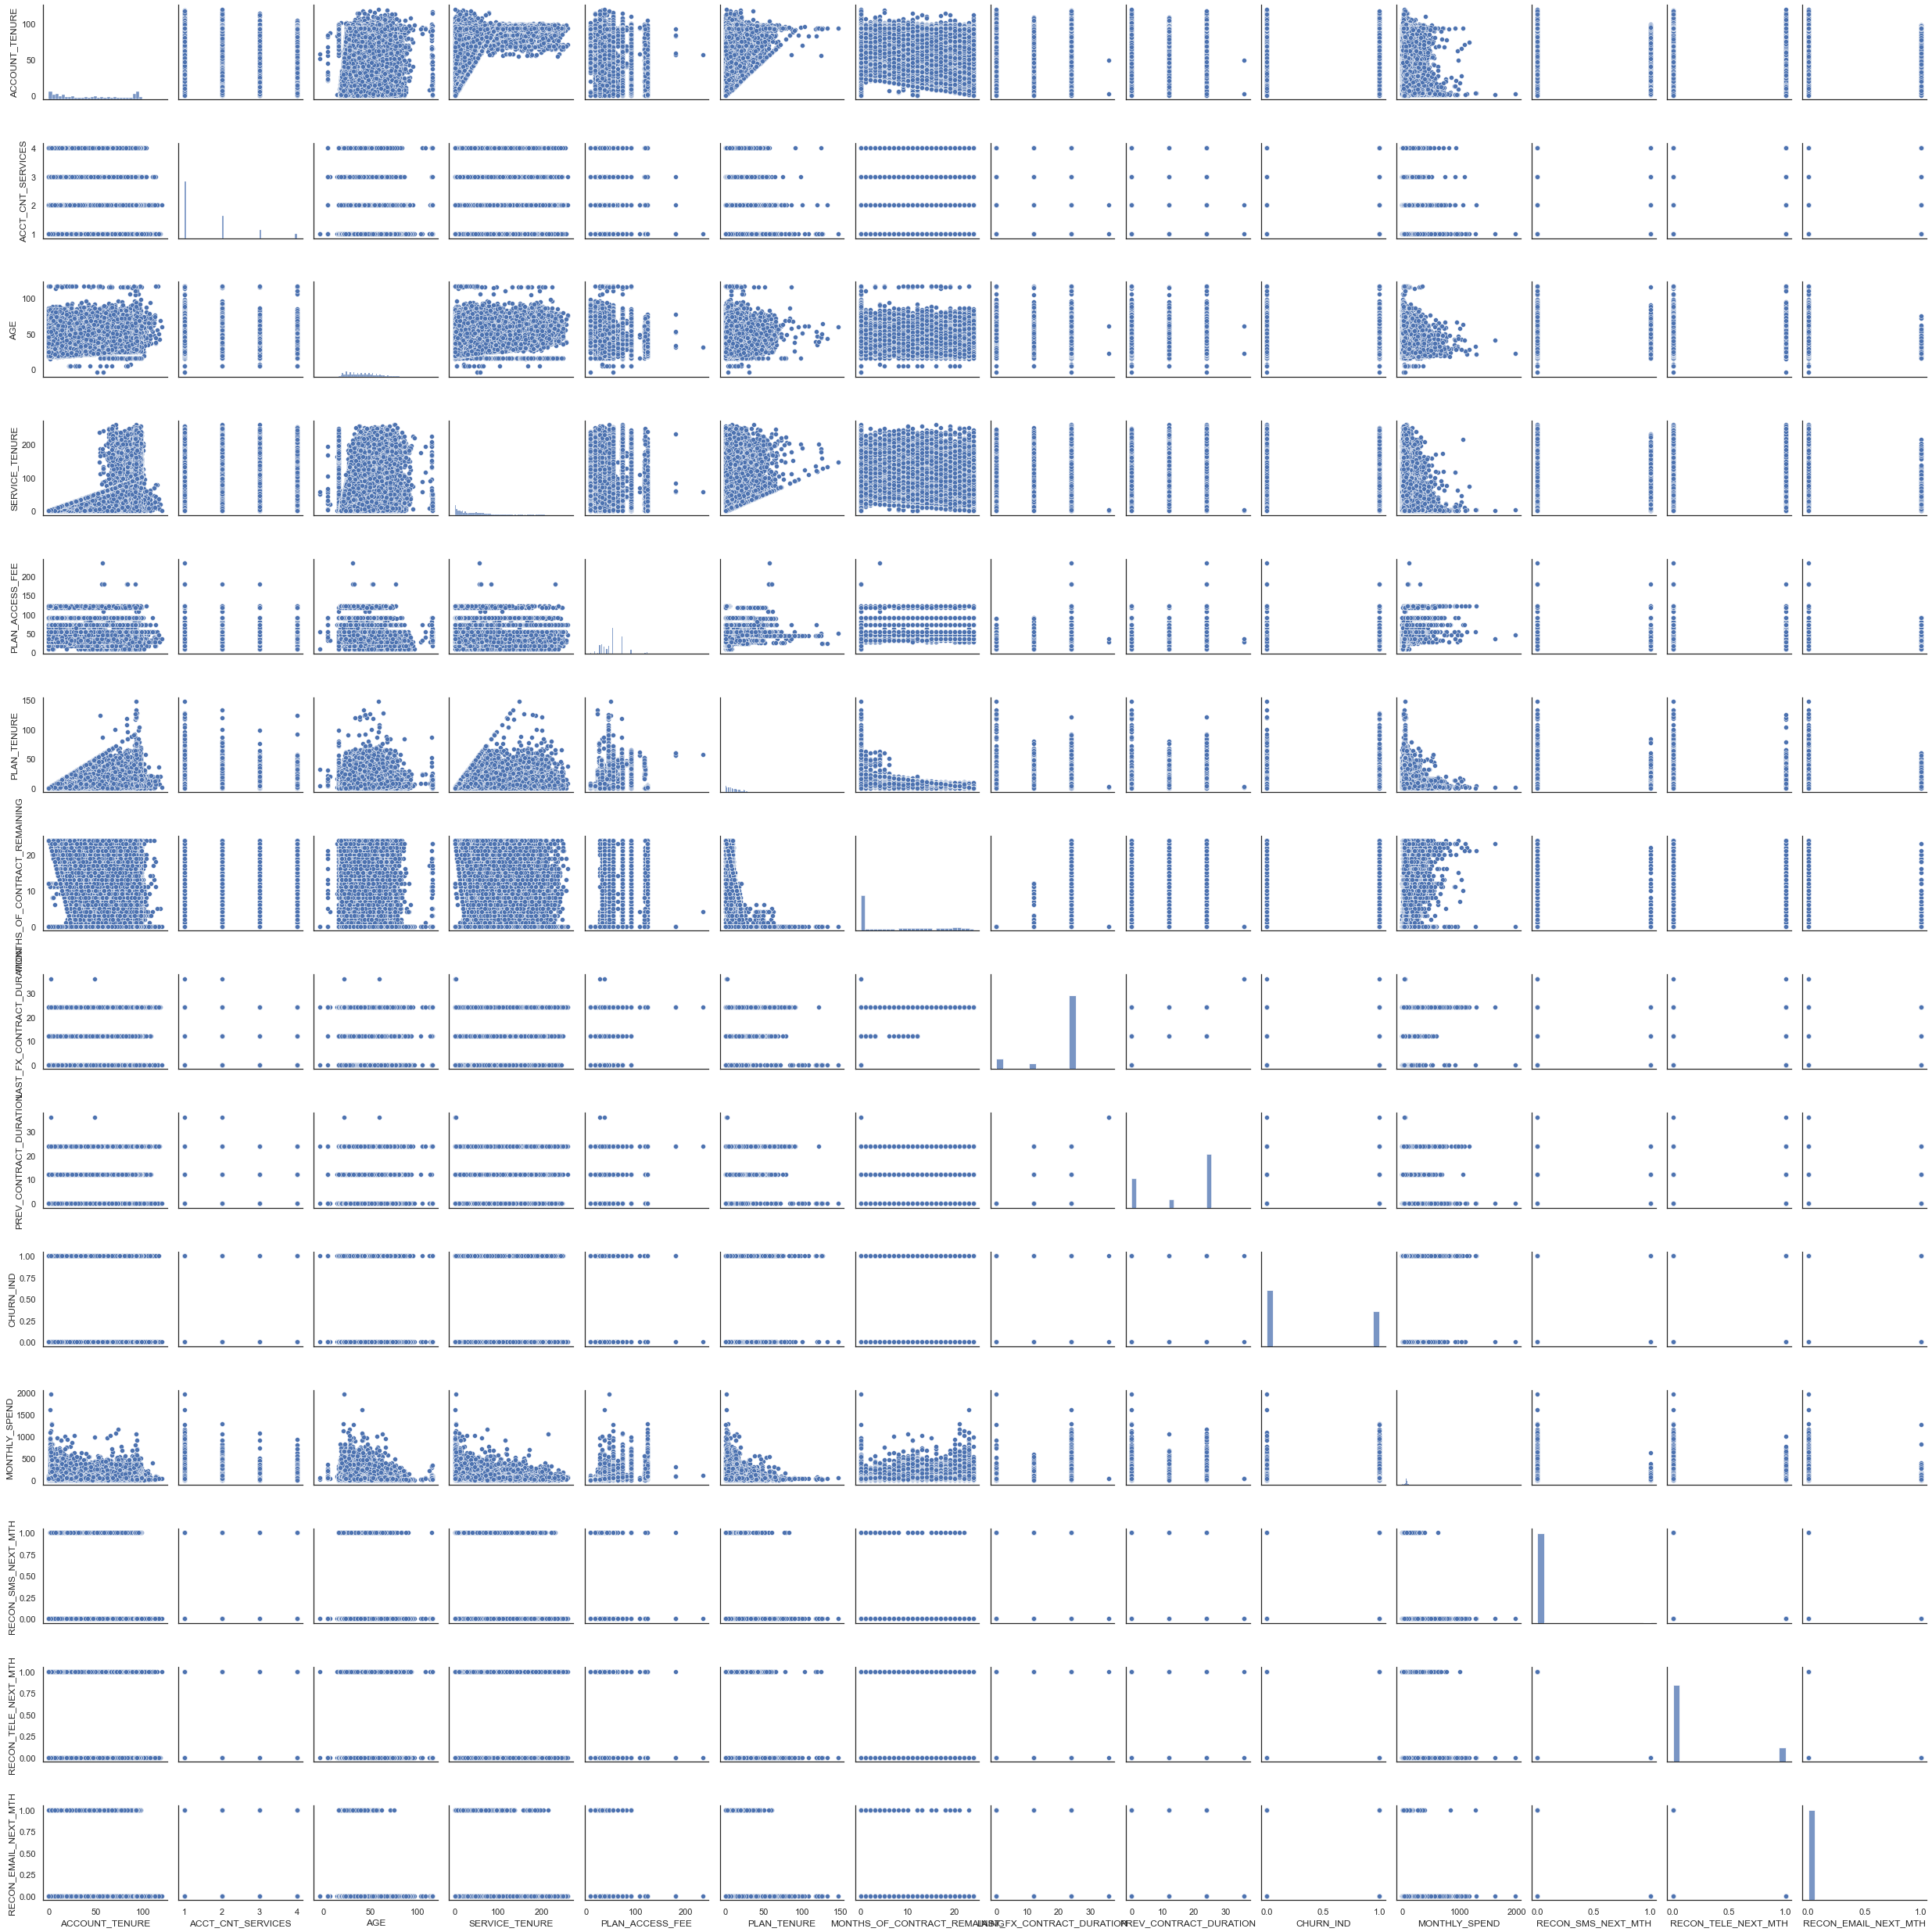

In [81]:
# Draw a pair-plot amongst for all attributes expect 'CUST_ID'
sns.pairplot(churn.iloc[:,1:])

In [82]:
churn.iloc[:,1:].corr()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
ACCOUNT_TENURE,1.000000,0.196271,0.249559,0.791784,-0.085160,0.247583,-0.170644,0.176972,0.503690,-0.151654,-0.137805,0.025489,0.057353,0.017585
ACCT_CNT_SERVICES,0.196271,1.000000,0.157241,0.068398,-0.003269,-0.041421,0.023829,0.001411,0.021421,-0.062390,-0.018687,-0.010493,0.073034,-0.005758
AGE,0.249559,0.157241,1.000000,0.251257,-0.346361,0.053363,-0.185124,-0.143354,0.007942,-0.114914,-0.208742,-0.025228,0.299828,-0.030274
SERVICE_TENURE,0.791784,0.068398,0.251257,1.000000,-0.078520,0.218260,-0.143886,0.139710,0.410986,-0.153512,-0.115622,0.025748,0.055966,0.015466
PLAN_ACCESS_FEE,-0.085160,-0.003269,-0.346361,-0.078520,1.000000,-0.058190,0.470779,0.393517,0.135970,-0.036587,0.448051,-0.022771,-0.077698,-0.005403
PLAN_TENURE,0.247583,-0.041421,0.053363,0.218260,-0.058190,1.000000,-0.429791,0.126140,0.184189,0.141586,-0.058206,0.052650,-0.018724,0.038907
MONTHS_OF_CONTRACT_REMAINING,-0.170644,0.023829,-0.185124,-0.143886,0.470779,-0.429791,1.000000,0.424067,-0.009699,-0.247269,0.302084,-0.064136,0.017783,-0.041567
LAST_FX_CONTRACT_DURATION,0.176972,0.001411,-0.143354,0.139710,0.393517,0.126140,0.424067,1.000000,0.521020,-0.066734,0.218200,0.001612,-0.006028,0.007653
PREV_CONTRACT_DURATION,0.503690,0.021421,0.007942,0.410986,0.135970,0.184189,-0.009699,0.521020,1.000000,-0.064199,-0.010426,0.009832,0.015369,0.009989
CHURN_IND,-0.151654,-0.062390,-0.114914,-0.153512,-0.036587,0.141586,-0.247269,-0.066734,-0.064199,1.000000,0.187608,-0.035586,-0.116290,-0.021407


From the above plots it can be seen:

* ACCOUNT_TENURE & SERVICE_TENURE are highly correlated 
* ACCOUNT_TENURE & PREV_CONTRACT_DURATION are moderately correlated 
* SERVICE_TENURE & PREV_CONTRACT_DURATION are moderately correlated 
* MONTHS_OF_CONTRACT_REMAINING & PLAN_ACCESS_FEE are moderately correlated 
* MONTHLY_SPEND & PLAN_ACCESS_FEE are moderately correlated